### Import Libraries

In [ ]:
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

file_dir = "."
sys.path.append(file_dir)
from parameters import Config

In [ ]:
def load_data(config: object) -> object:
    """
    check if the data is already prepared for the model
    :param config: object
    :return tmp: object containing data and other parameters
    """
    if os.path.isfile(config.pickle_path):
        print(f'Loading existing data for {config.mode} model')
        with open(config.pickle_path, 'rb') as pfile:
            tmp = pickle.load(pfile)
            return tmp
    else:
        raise RuntimeError('No pickle file exist')


class myCallback(tf.keras.callbacks.Callback):
    """
    Control how much the model will train.
    """
    def __init__(self, accuracy_threshold=0.9, print_message=True):
        self.accuracy_threshold = accuracy_threshold
        self.print_message = print_message

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > self.accuracy_threshold:
            if self.print_message:
                print("\n90% accuracy reached. stopping training....")
            self.model.stop_training = True
        else:
            if self.print_message:
                print("Accuracy not high enough. continue training....")

def plot_loss_accuracy(model, target_accuracy=0.9, title=None):
    """
    :param model: The trained model
    :param target_accuracy: Accuracy we want to achieve
    :param title: title of the graph
    :return:
    """
    epoch_ = np.array(model.history.epoch) + 1  
    loss_ = np.array(model.history.history['loss'])
    accuracy_ = np.array(model.history.history['acc'])

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Loss', color=color, fontsize=15)
    ax1.plot(epoch_, loss_, color=color, lw=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color, fontsize=15)  
    ax2.plot(epoch_, accuracy_, color=color, lw=2)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    if title != None:
        plt.title(title)
    plt.hlines(y=target_accuracy, xmin=1, xmax=epoch_.max(), colors='k', linestyles='dashed', lw=3)


def compile_train_model(model, x_train:np.ndarray, y_train: np.ndarray, callbacks=None,
                        learning_rate=0.001, batch_size=32, epochs=10, verbose=1):
    """
    Compiles and train a given model. Uses Adam Optimizer
    :param model: The model to train
    :param x_train: Training data
    :param y_train: Training label
    :param callbacks: controls how the model will be trained
    :param learning_rate: learning rate for the optimizer
    :param batch_size: mini-batch size
    :param epochs: number of epochs to train
    :param verbose: Verbosity of training
    :return: trained_model
    """
    # get the index of each class label
    y_index = np.argmax(y_train, axis=1)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    # to remove class inbalance
    class_weight = compute_class_weight('balanced', np.unique(y_index), y_index)

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True,
              class_weight=class_weight, validation_split=0.1, callbacks=[callbacks],
              verbose=verbose)
    
def get_conv_model(input_shape: tuple) -> Model:
    
    # shape of data for Conv is (n, time, feature, 1)
    inp = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(inp)
    x = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
    
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    
    x = Dense(64, activation='relu')(x)
    out = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    
    model.summary()

    return model

### Model

In [ ]:
config = Config(file_path=file_dir, mode='conv')
dataset = load_data(config)

if config.mode == 'conv':
    x_train, y_train = dataset['X'], dataset['y']
    # input_shape for keras conv
    input_shape = (x_train.shape[1], x_train.shape[2], 1)
    model = get_conv_model(input_shape=input_shape)


callbacks = myCallback(accuracy_threshold=0.9)
compile_train_model(model, x_train, y_train, callbacks=callbacks, verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9, 13, 1)]        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0   

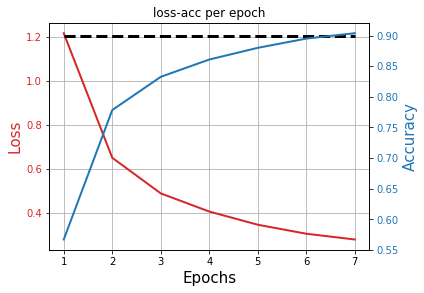

In [ ]:
plot_loss_accuracy(model, target_accuracy=0.9, title="loss-acc per epoch")
plt.savefig(os.path.join(file_dir, 'loss-acc.png'), bbox_inches='tight')
plt.show()